**Data mining Project - University of Pisa, acedemic year 2023/24**

**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Intrinsic feature importance

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

In [2]:
# load models and predictions
data_dir = '../data/classification_results/'
DT = 'DecisionTreeClassifier'
RF = 'RandomForestClassifier'
XGB = 'ExtremeGradientBoostingClassifier'
AB = 'AdaBoostClassifier'
NC = 'NearestCentroidClassifier'
KNN = 'KNearestNeighborsClassifier'
SVM = 'SupportVectorMachineClassifier'
NN = 'NeuralNetworkClassifier'
TN = 'TabNetClassifier'
RIPPER = 'RipperClassifier'
EBM = 'ExplainableBoostingMachineClassifier'
NB = 'NaiveBayesMixedClassifier'
# load the data
incidents_train_df = pd.read_csv('../data/clf_indicators_train.csv', index_col=0)
true_labels_train_df = pd.read_csv('../data/clf_y_train.csv', index_col=0)
true_labels_train = true_labels_train_df.values.ravel()

incidents_test_df = pd.read_csv('../data/clf_indicators_test.csv', index_col=0)
true_labels_test_df = pd.read_csv('../data/clf_y_test.csv', index_col=0)

# load the names of the features
features_db = json.loads(open('../data/clf_indicators_names_distance_based.json').read())
features_rb = json.loads(open('../data/clf_indicators_names_rule_based.json').read())

# project on the used features
indicators_train_db_df = incidents_train_df[features_db]
indicators_train_rb_df = incidents_train_df[features_rb]
indicators_test_db_df = incidents_test_df[features_db]
indicators_test_rb_df = incidents_test_df[features_rb]

In [3]:
clf_names = [DT, RF, XGB, AB, TN, EBM]
feature_imp = {}
for clf in clf_names:
    feature_imp[clf] = {}
    clf_feature_imp = pd.read_csv(data_dir+clf+'_feature_importances.csv')
    feature_imp[clf]['features_names'] = clf_feature_imp['features']
    feature_imp[clf]['features_importance'] = clf_feature_imp['importances']
    feature_imp[clf]['features_rank'] = clf_feature_imp['rank']

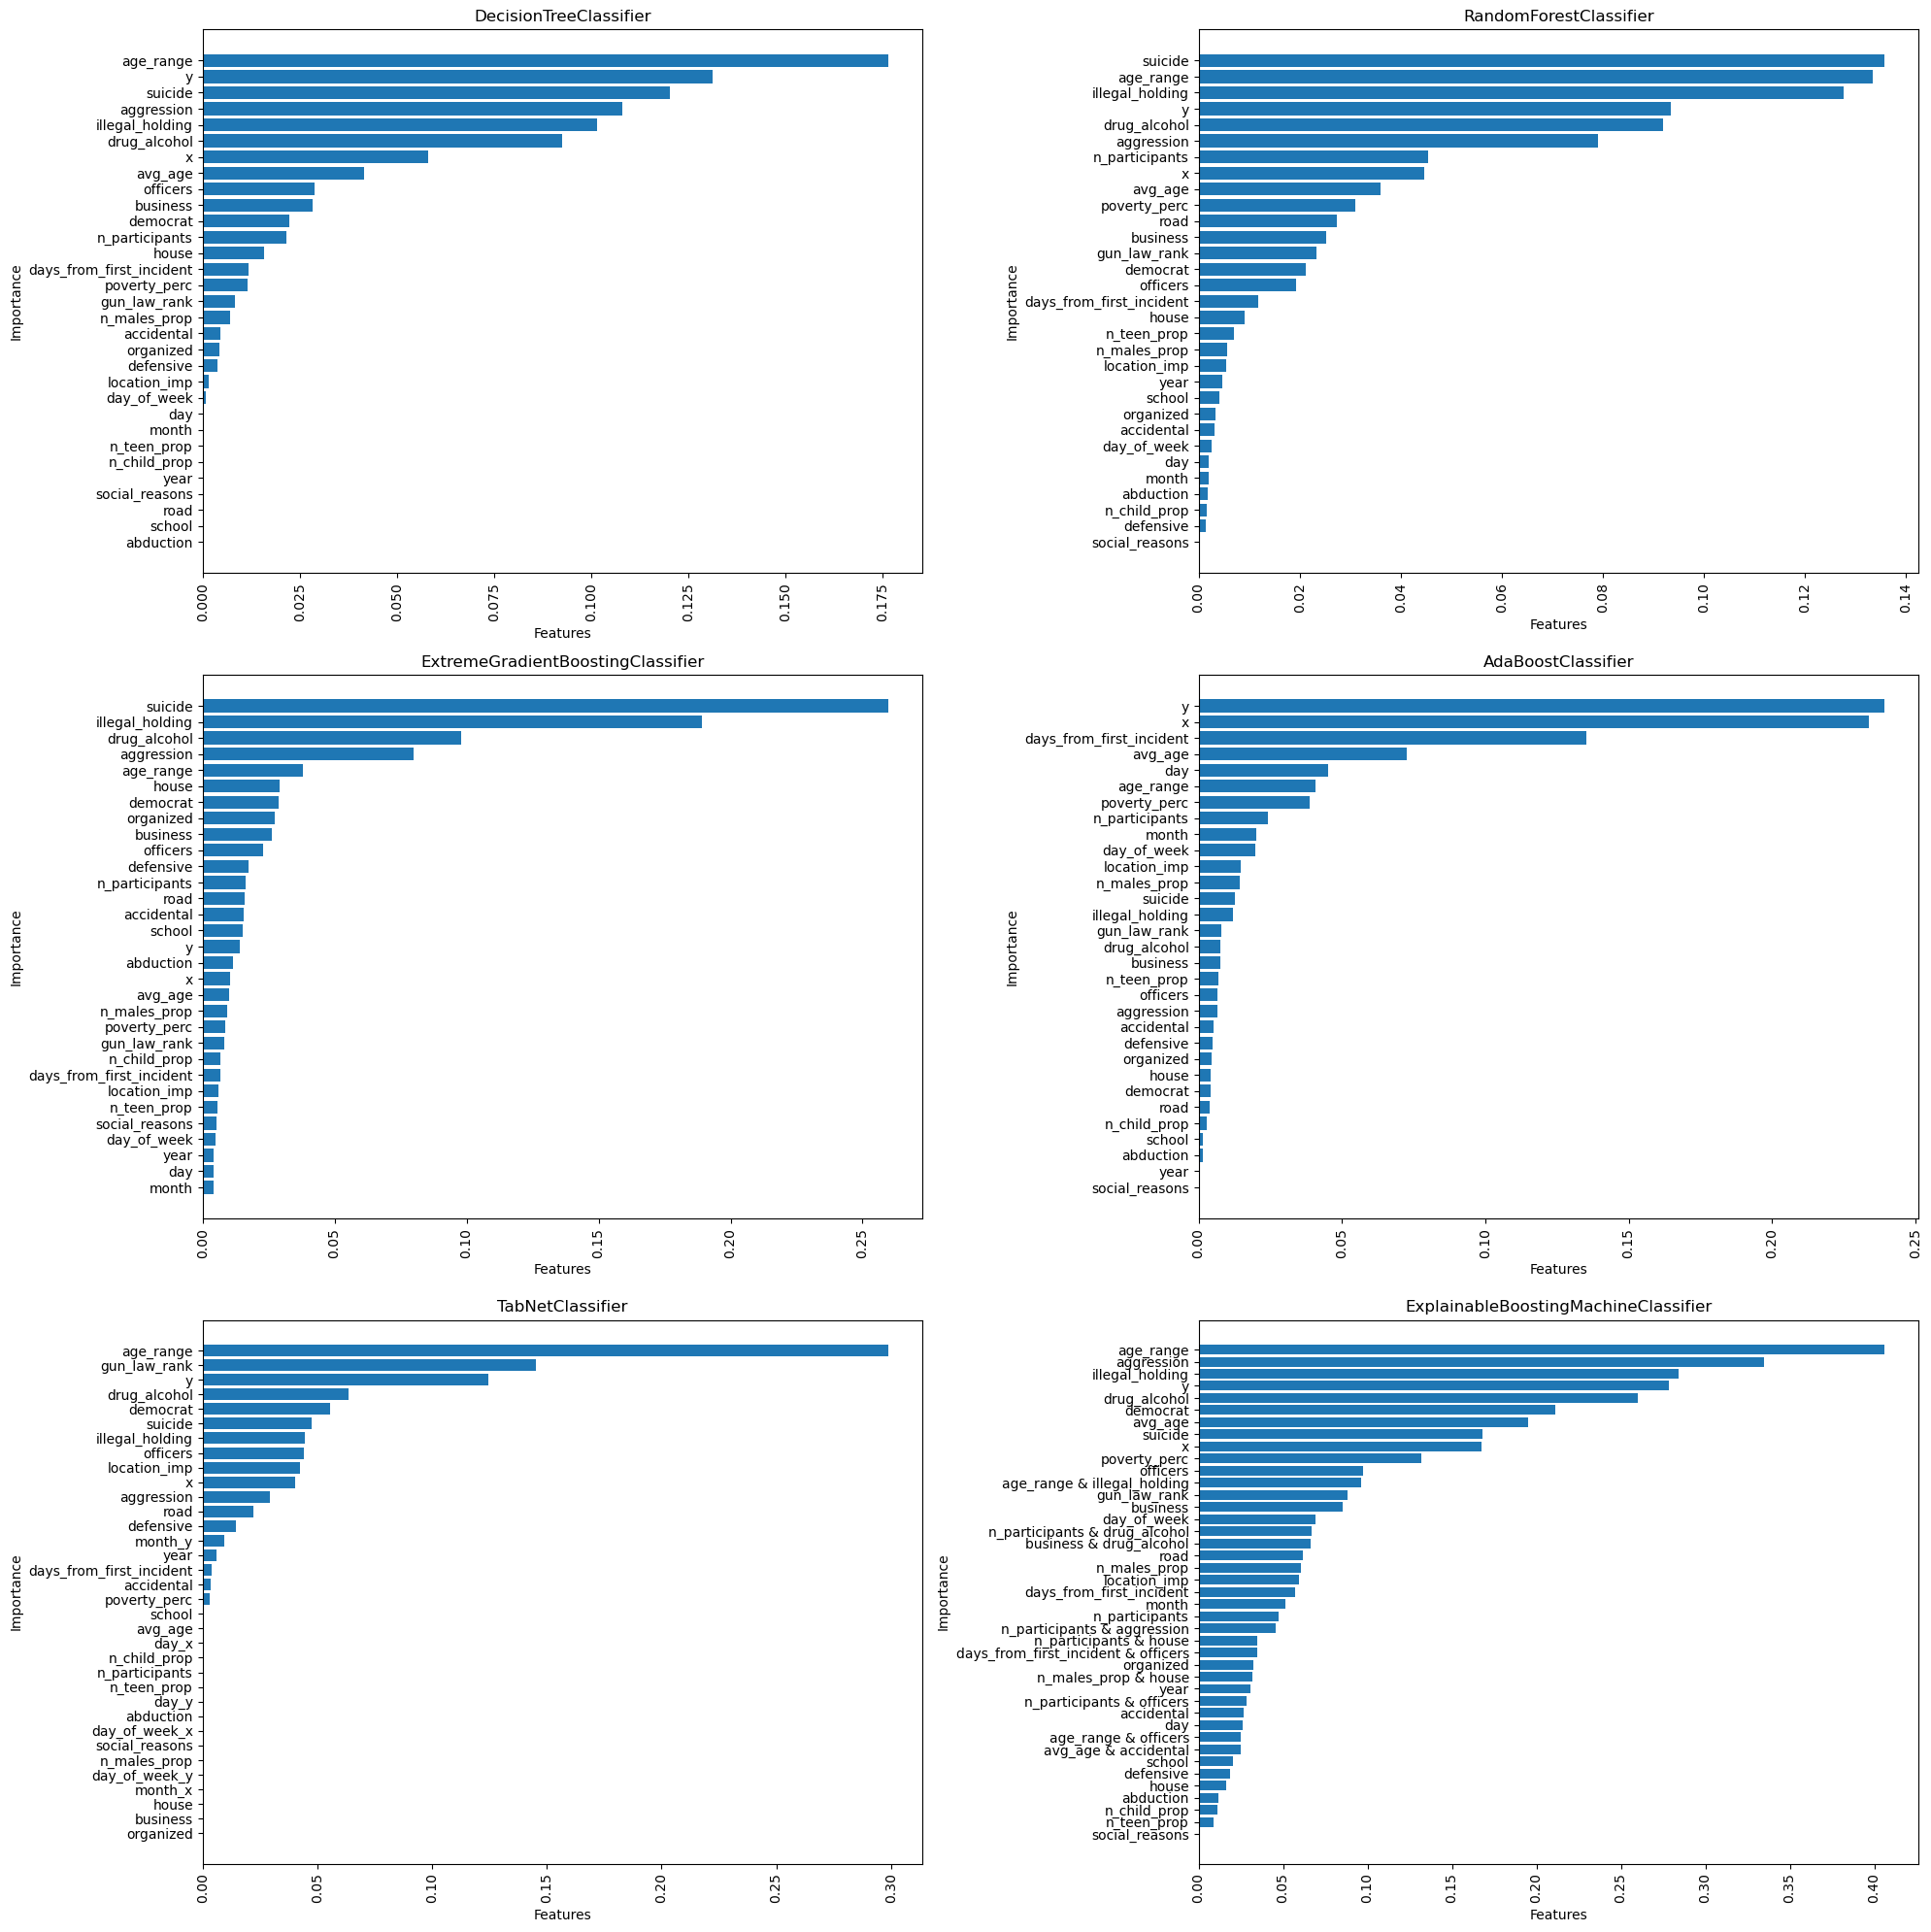

In [4]:
ncols = 2
nplots = len(clf_names)
nrows = int(nplots/ncols)
if nplots % ncols != 0:
    nrows += 1
f, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,20), squeeze=False)
for i, clf in enumerate(clf_names):
    sorted_idx = np.argsort(feature_imp[clf]['features_importance'])
    axs[int(i/ncols)][i%ncols].barh(
        y=np.array(feature_imp[clf]['features_names'])[sorted_idx],
        width=np.array(feature_imp[clf]['features_importance'])[sorted_idx],
    )

    axs[int(i/ncols)][i%ncols].set_title(clf)
    axs[int(i/ncols)][i%ncols].set_xlabel('Features')
    axs[int(i/ncols)][i%ncols].set_ylabel('Importance')
    for tick in axs[int(i/ncols)][i%ncols].get_xticklabels():
        tick.set_rotation(90);
plt.tight_layout()

In [5]:
features = features_db.copy()
for feature in features_rb:
    if feature not in features:
        features.append(feature)
importances = {}
for i, clf in enumerate(clf_names):
    importances[clf] = []
    clf_features = feature_imp[clf]['features_names'].to_list()
    for feature in features:
        if feature in clf_features:
            importances[clf].append(feature_imp[clf]['features_importance'][clf_features.index(feature)])
        else:
            importances[clf].append(np.nan)

In [6]:
importances_df = pd.DataFrame(importances, index=features)
importances_df.style.background_gradient(cmap='Blues', axis=1)

In [7]:
importances_df.sum(axis=0)

DecisionTreeClassifier                  1.000000
RandomForestClassifier                  1.000000
ExtremeGradientBoostingClassifier       1.000000
AdaBoostClassifier                      1.000000
TabNetClassifier                        1.000000
ExplainableBoostingMachineClassifier    3.316882
dtype: float64

Text(0.5, 1.0, 'Feature importance')

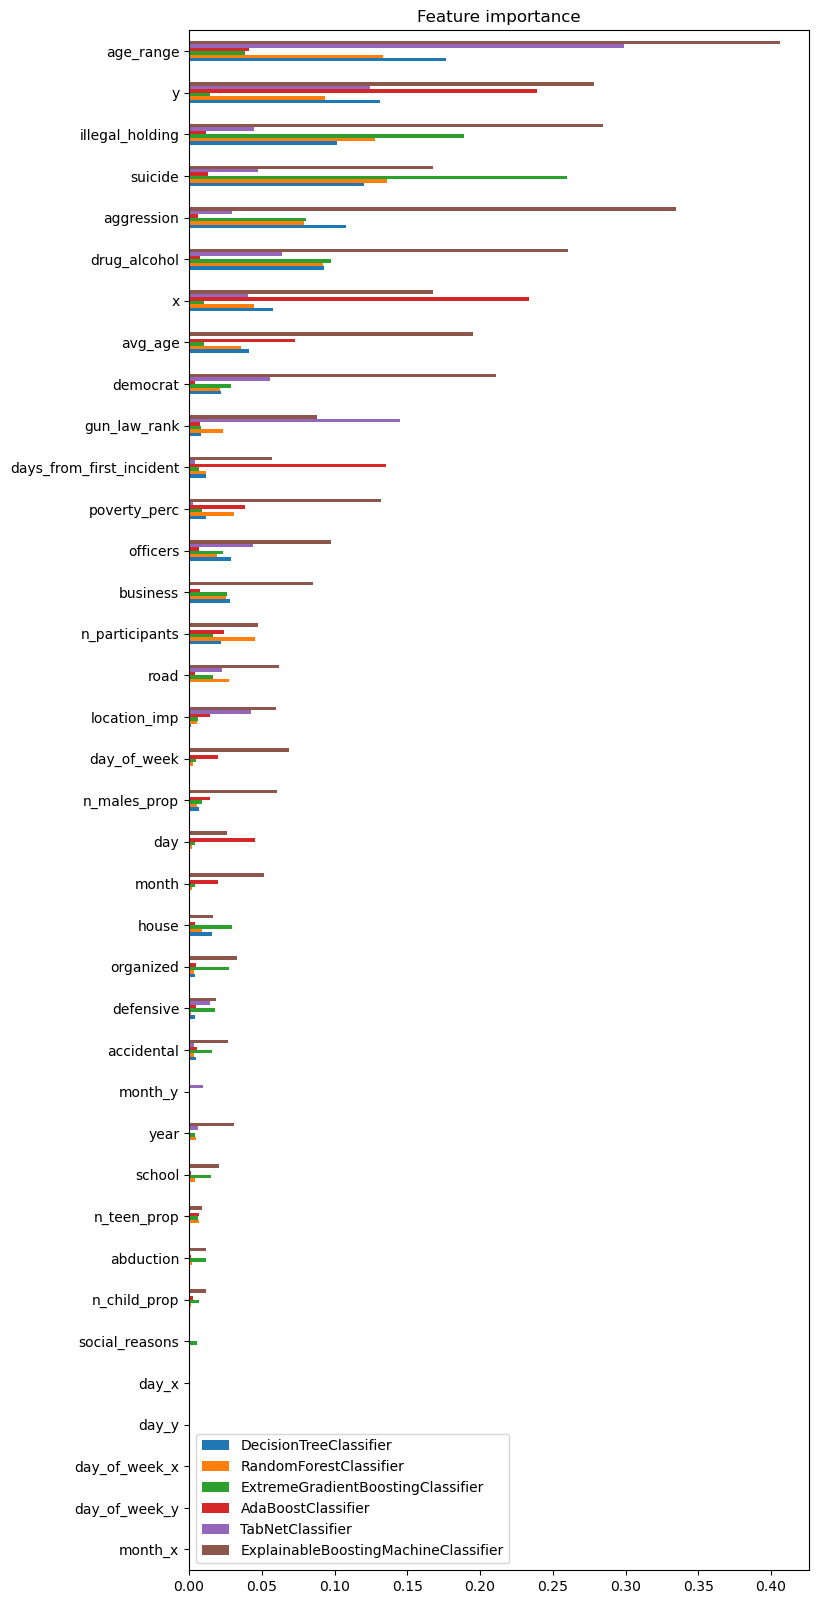

In [8]:
importances_df = importances_df.loc[importances_df.mean(axis=1).sort_values(ascending=True).index]
importances_df.plot.barh(figsize=(8, 20))
plt.title('Feature importance')

## Nearest Centroid

In [9]:
with open(data_dir+NC+'.pkl', 'rb') as file:
    nc = pickle.load(file)

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator NearestCentroid from version 1.3.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [10]:
len(features_db)

34

<Axes: title={'center': 'Centroids'}, xlabel='Features'>

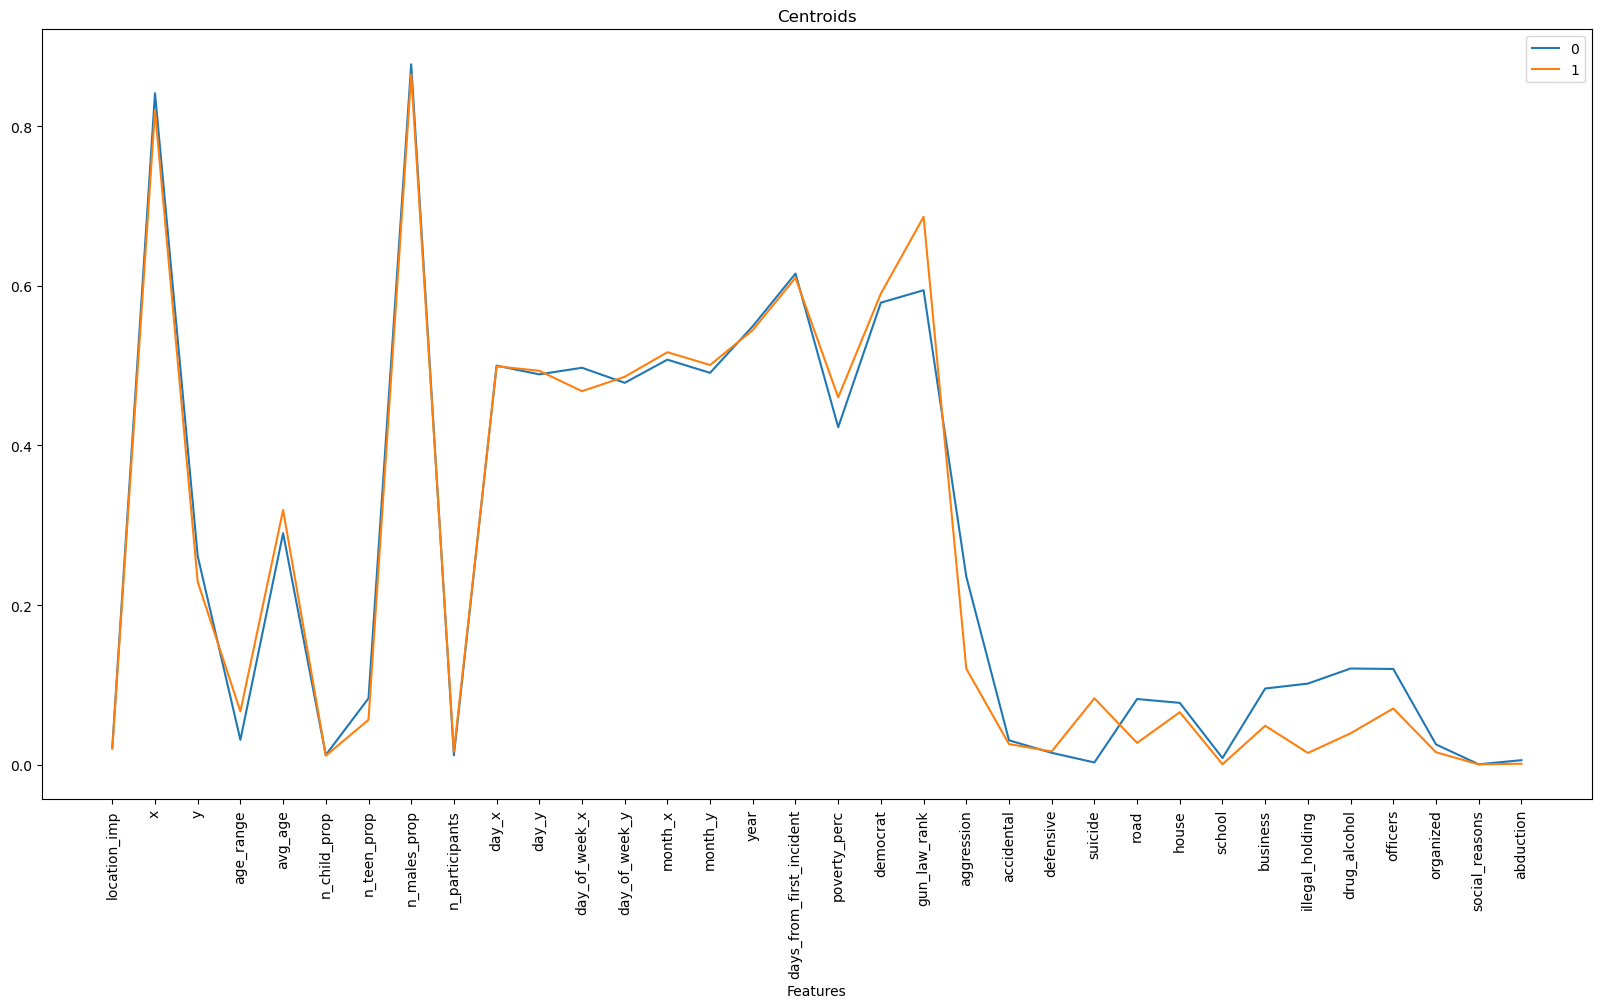

In [11]:
pd.DataFrame(nc.centroids_, columns=features_db).T.plot(
    kind='line',
    title='Centroids',
    xlabel='Features',
    rot=90,
    xticks=range(len(features_db)),
    figsize=(20, 10)
)

## K Nearest Neighbors

In [12]:
with open(data_dir+KNN+'.pkl', 'rb') as file:
    knn = pickle.load(file)

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.3.1 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
graph_matrix = knn.kneighbors_graph(
    indicators_train_db_df[:1000],
    mode='distance',
    n_neighbors=1000
).toarray()

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


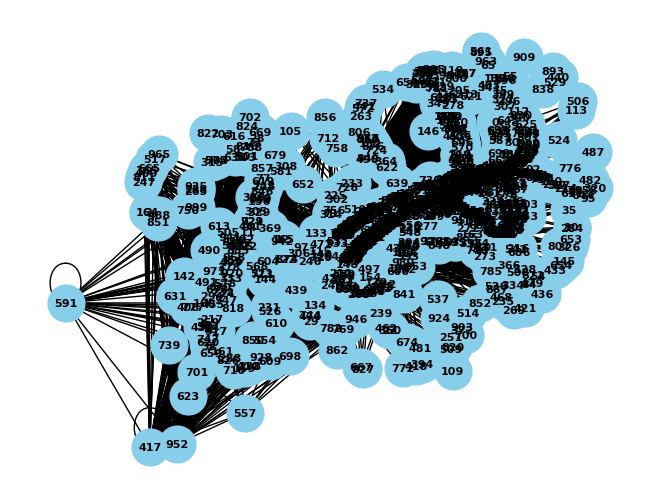

In [14]:
G = nx.from_numpy_array(graph_matrix[:,:1000])
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8)
plt.show()

## TabNet

In [15]:
# load the model
tn = TabNetClassifier()
tn.load_model(data_dir+TN+'.pkl.zip')

/Users/irenetesta/anaconda3/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [16]:
# explain
minmax_scaler = MinMaxScaler()
indicators_train_scaled = minmax_scaler.fit_transform(indicators_train_db_df)
explain_matrix, masks = tn.explain(indicators_train_scaled)

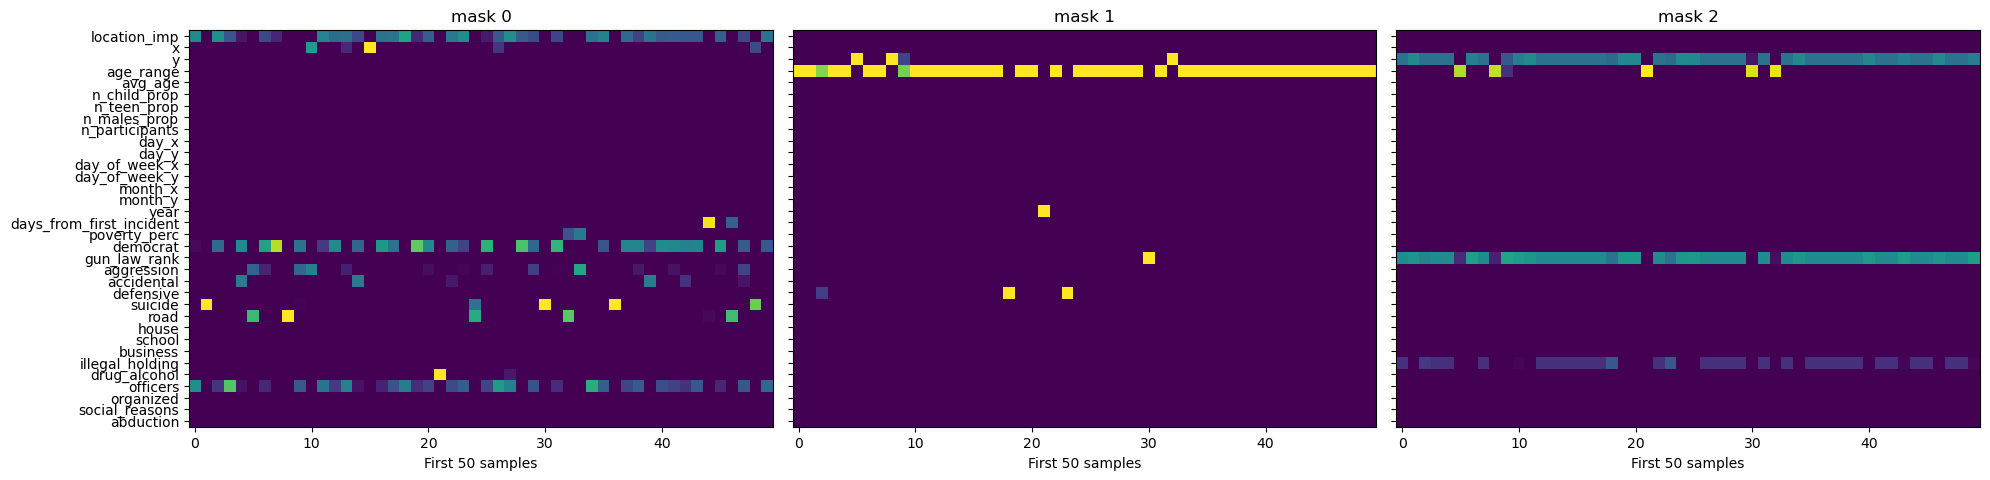

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(20,30), sharey=True)
for i in range(3):
    axs[i].imshow(masks[i][:50].T)
    axs[i].set_title(f"mask {i}")
    axs[i].set_yticks(np.arange(len(features_db)))
    axs[i].set_yticklabels(labels = features_db)
    axs[i].set_xlabel('First 50 samples')
fig.tight_layout()

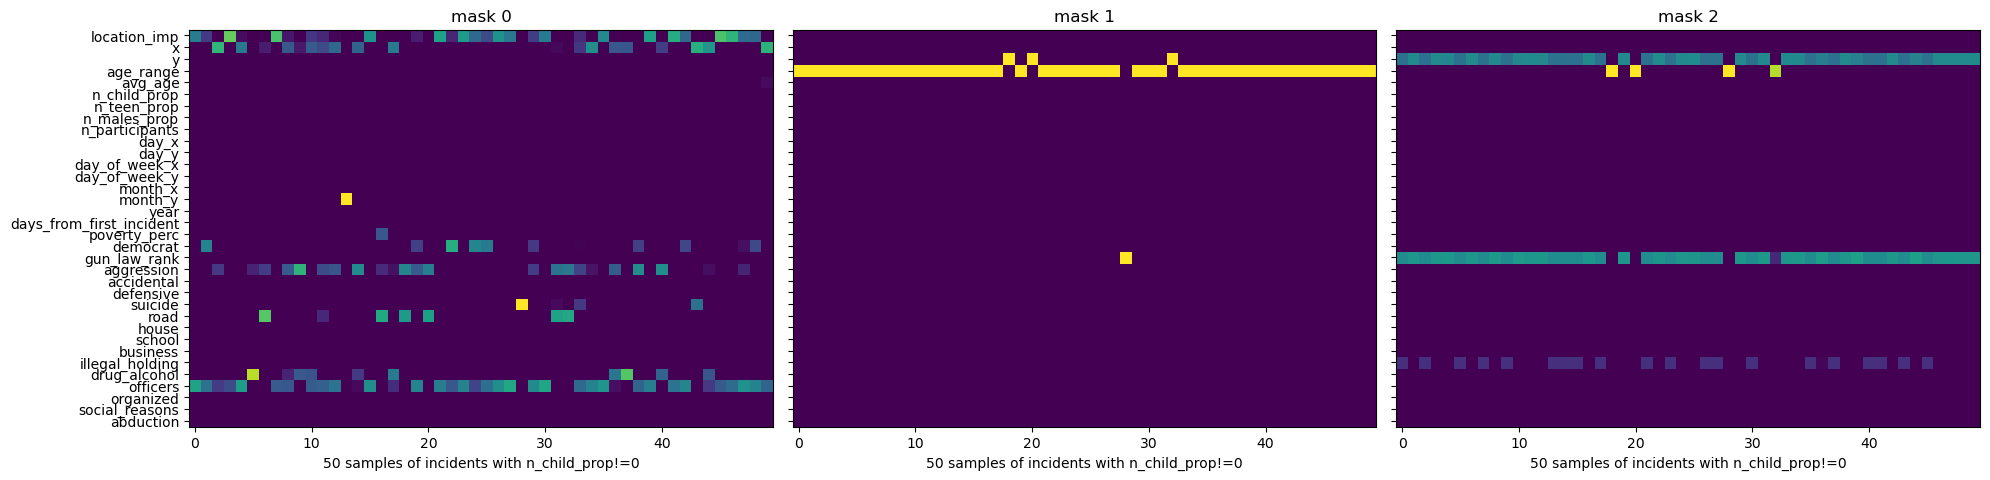

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20,40), sharey=True)
for i in range(3):
    axs[i].imshow(masks[i][np.where(indicators_train_db_df['n_child_prop']!=0)[0][:50]].T)
    axs[i].set_title(f"mask {i}")
    axs[i].set_yticks(np.arange(len(features_db)))
    axs[i].set_yticklabels(labels = features_db)
    axs[i].set_xlabel('50 samples of incidents with n_child_prop!=0')
fig.tight_layout()

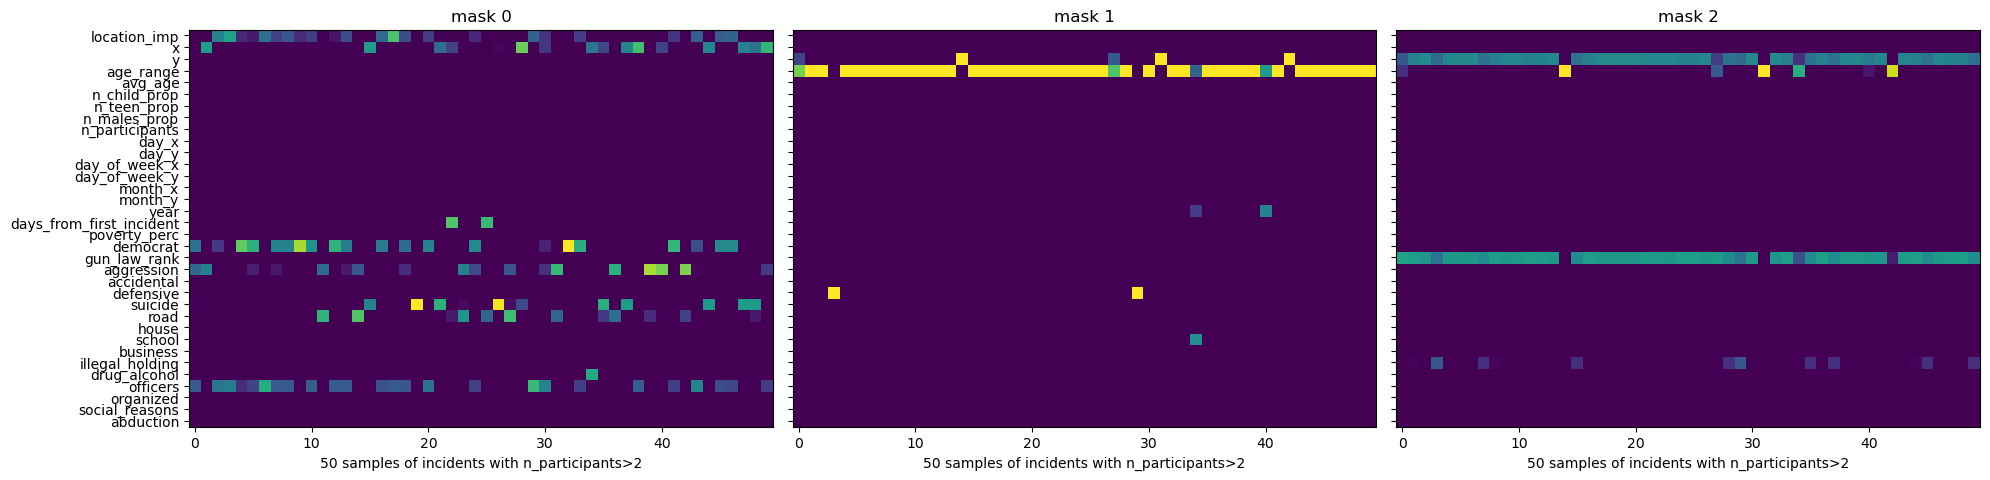

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(20,40), sharey=True)
for i in range(3):
    axs[i].imshow(masks[i][np.where(indicators_train_db_df['n_participants']>2)[0][:50]].T)
    axs[i].set_title(f"mask {i}")
    axs[i].set_yticks(np.arange(len(features_db)))
    axs[i].set_yticklabels(labels = features_db)
    axs[i].set_xlabel('50 samples of incidents with n_participants>2')
fig.tight_layout()

## Decision Tree

In [20]:
# load the model
with open(data_dir+DT+'.pkl', 'rb') as file:
    dt = pickle.load(file)

In [21]:
dot_data = export_graphviz(
    dt,
    out_file=None, 
    feature_names=list(indicators_train_rb_df.columns),
    filled=True,
    rounded=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Ripper

In [22]:
# load the model
with open(data_dir+RIPPER+'.pkl', 'rb') as file:
    ripper = pickle.load(file)

In [23]:
ripper.out_model()

[[suicide=1 ^ gun_law_rank=>12.0 ^ days_from_first_incident=<559.0] V
[suicide=1 ^ n_males_prop=<0.5 ^ age_range=4.0-12.0] V
[gun_law_rank=>12.0 ^ aggression=0 ^ illegal_holding=0 ^ drug_alcohol=0 ^ age_range=>12.0 ^ suicide=1] V
[gun_law_rank=>12.0 ^ aggression=0 ^ democrat=1.0 ^ illegal_holding=0 ^ drug_alcohol=0 ^ officers=0 ^ x=784783.45-1282365.91 ^ y=<3404540.76 ^ poverty_perc=13.6-14.5 ^ day_of_week=6] V
[aggression=0 ^ gun_law_rank=>12.0 ^ democrat=1.0 ^ illegal_holding=0 ^ drug_alcohol=0 ^ officers=0 ^ x=784783.45-1282365.91 ^ y=<3404540.76 ^ defensive=0 ^ poverty_perc=13.6-14.5 ^ n_males_prop=>0.67 ^ n_child_prop=<0.1] V
[aggression=0 ^ gun_law_rank=>12.0 ^ illegal_holding=0 ^ drug_alcohol=0 ^ age_range=>12.0 ^ n_participants=>3.0 ^ n_child_prop=<0.1 ^ democrat=1.0 ^ n_males_prop=>0.67 ^ x=-897668.54-784783.45] V
[aggression=0 ^ gun_law_rank=>12.0 ^ illegal_holding=0 ^ drug_alcohol=0 ^ age_range=>12.0 ^ n_participants=>3.0 ^ n_child_prop=<0.1 ^ days_from_first_incident=<559.0